In [1]:
import numpy as np
import numpyro
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
from multiprocessing import Pool
from astropy.table import Table
from astropy.io import fits
import fitsio
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
import numpyro.distributions as dist
import fitting5
from astropy.cosmology import Planck18

In [2]:
print(jax.devices())

[cuda(id=0)]


In [3]:
array = np.array([1,2,3])
array1 = np.array([1,2,3,4])
array2 = np.array([1,2,3,4,5])
array1 = array1[:,None]
array2 = array2[:,None,None]
print((array+array1+array2).shape)
print()

(5, 4, 3)



In [4]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [5]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]
Computation result: [1. 4. 9.]


In [6]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k1.csv',format='csv')
indice = np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
#k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [7]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
print(d[SEL]['TARGETID'][16171])
print(d[SEL]['TARGETID'].shape)
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]

39627637697547336
(168482,)


In [8]:
bad_tid = 39627637697547336

# Create mask to exclude the target
mask_good = TARGETID != bad_tid

# Apply to all arrays
TARGETID = TARGETID[mask_good]
apr_mag_r = apr_mag_r[mask_good]
apr_mag_r_err = apr_mag_r_err[mask_good]
z_desi = z_desi[mask_good]
k_rr = k_rr[mask_good]

In [9]:
d_desi = Planck18.distmod(z_desi).value

In [10]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [11]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.6)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

116959


In [12]:
#apr_mag_g = apr_mag_g.astype(np.float64)
#apr_mag_g_err = apr_mag_g_err.astype(np.float64)
#k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d_desi = d_desi.astype(np.float64)
z_desi = z_desi.astype(np.float64)

In [13]:
apr_mag_r = jnp.array(apr_mag_r)
apr_mag_r_err = jnp.array(apr_mag_r_err)
k_rr = jnp.array(k_rr)
d_desi = jnp.array(d_desi)
z_desi = jnp.array(z_desi)

In [14]:
gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20 = fitting5.get_lfpars_shen20(2.35)
alpha_shen20 = -(gamma1_shen20+1)
beta_shen20 = -(gamma2_shen20+1)

In [15]:
print(gamma1_shen20, gamma2_shen20, L_star_shen20, phi_star_shen20)

0.4101099999999999 2.50877883045515 4.5433620711936776e+46 1.37670217962694e-05


In [ ]:
def eff(m,b,m0):
    eff = jnp.where(m<m0,1,10**(-b*(m-m0)/2.5))
    return eff

ln_posterior3 = fitting5.ln_posterior3(eff)
def model(apr_mag, sigma, k, mu, z):
    # Quadratic evolution for m0(z)
    a_m0 = numpyro.sample('a_m0', dist.Uniform(-30, 30))
    b_m0 = numpyro.sample('b_m0', dist.Uniform(-30, 30))
    c_m0 = numpyro.sample('c_m0', dist.Uniform(10, 25))

    # Quadratic evolution for b(z)
    a_b = numpyro.sample('a_b', dist.Uniform(-20, 20))
    b_b = numpyro.sample('b_b', dist.Uniform(-20, 20))
    c_b = numpyro.sample('c_b', dist.Uniform(0, 1.5))

    # Quadratic evolution for log10 L_star(z)
    aL = numpyro.sample('aL', dist.Uniform(-20, 20))
    bL = numpyro.sample('bL', dist.Uniform(-20, 20))
    cL = numpyro.sample('cL', dist.Uniform(36, 56))

    # Quadratic evolution for log10 phi_star(z)
    aP = numpyro.sample('aP', dist.Uniform(-20, 20))
    bP = numpyro.sample('bP', dist.Uniform(-20, 20))
    cP = numpyro.sample('cP', dist.Uniform(-10, 0))

    # Linear evolution for beta(z)
    a_beta = numpyro.sample('a_beta', dist.Uniform(-10, 10))
    b_beta = numpyro.sample('b_beta', dist.Uniform(-4, -2))

    # Linear evolution for alpha(z)
    a_alpha = numpyro.sample('a_alpha', dist.Uniform(-10, 10))
    b_alpha = numpyro.sample('b_alpha', dist.Uniform(b_beta, 0))  # Enforce α > β generally

    # Call hybrid log-likelihood (using updated ln_posterior3)
    log_likelihood = ln_posterior3(
        a_m0, b_m0, c_m0,
        a_b, b_b, c_b,
        aL, bL, cL,
        aP, bP, cP,
        a_alpha, b_alpha,
        a_beta, b_beta,
        apr_mag, sigma, k, mu, z
    )

    numpyro.factor("log_likelihood", log_likelihoo

In [17]:
rng_key = random.PRNGKey(0)
# Sampler configuration
num_warmup, num_samples = 10000, 10000
i_start = 0
i_end = i_start+np.shape(apr_mag_r)[0]
#i_end = 1000
# Initialize batch parameters for the entire dataset

init_params = {
    'x': 1.5 * jnp.ones((1,)),  
    'm0': 18 * jnp.ones((1,)),
    'b': 0.5 * jnp.ones((1,)),
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1,jit_model_args=True, progress_bar=True)

# Run the sampler over thswwe entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g _err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, apr_mag_r[i_start:i_end],apr_mag_r_err[i_start:i_end],k_rr[i_start:i_end],d_desi[i_start:i_end],z_desi[i_start:i_end])
# Get samples
samples = mcmc.get_samples()
# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 20000/20000 [58:14<00:00,  5.72it/s, 255 steps of size 2.01e-02. acc. prob=0.93]  


{'aL': Array([-0.36013139, -1.81039861,  0.4985377 , ..., -0.37835163,
       -2.06118839,  0.78247591], dtype=float64), 'aP': Array([ 0.14013698,  2.0454414 , -2.63465539, ..., -0.5778135 ,
        1.85348273, -2.48712133], dtype=float64), 'a_alpha': Array([0.71751585, 0.47014133, 0.21135969, ..., 0.45464314, 0.17773402,
       0.42133575], dtype=float64), 'a_b': Array([ 0.05070752,  1.73955006, -1.95191753, ..., -0.21654033,
        2.40233553, -1.82409425], dtype=float64), 'a_beta': Array([ 0.33998867,  0.52248837,  0.42619018, ...,  0.37800962,
       -0.12531733,  0.70955205], dtype=float64), 'a_m0': Array([-12.34954086,  -8.15489446,  10.78834669, ...,  11.33398567,
        10.44448759,   6.69045253], dtype=float64), 'bL': Array([ 0.19664972,  0.04244948, -0.36946136, ..., -0.05910351,
       -0.03700934, -0.38912959], dtype=float64), 'bP': Array([0.01811605, 0.18504206, 0.86498003, ..., 0.41727766, 0.63950413,
       0.65661421], dtype=float64), 'b_alpha': Array([-0.84350417, -0

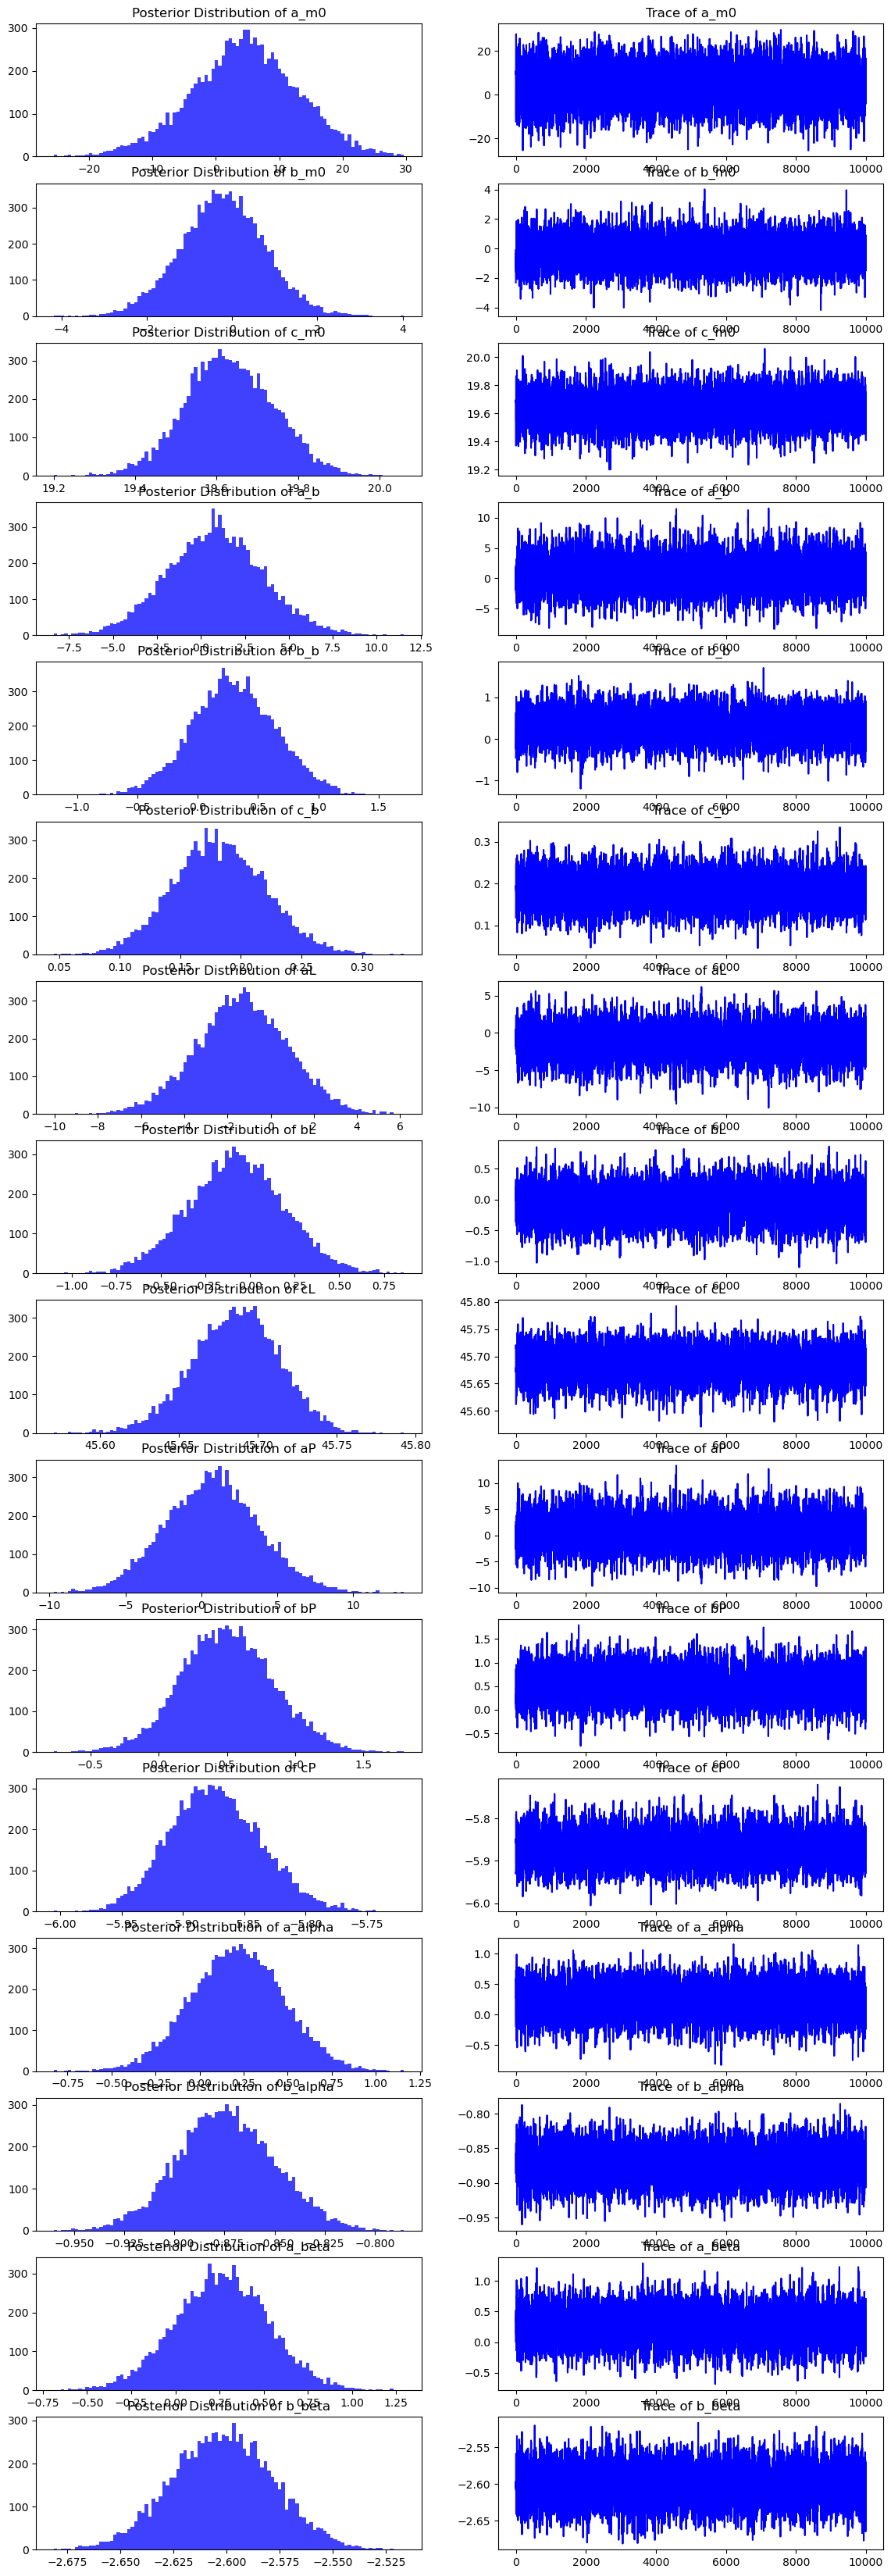

In [18]:
# Extract samples and save
samples = mcmc.get_samples()
np.savez("/pscratch/sd/z/zhaozhon/MCMC/mcmc_samples_evolution1.npz", **samples)

params = {
    'a_m0': samples['a_m0'],
    'b_m0': samples['b_m0'],
    'c_m0': samples['c_m0'],
    'a_b': samples['a_b'],
    'b_b': samples['b_b'],
    'c_b': samples['c_b'],
    'aL': samples['aL'],
    'bL': samples['bL'],
    'cL': samples['cL'],
    'aP': samples['aP'],
    'bP': samples['bP'],
    'cP': samples['cP'],
    'a_alpha': samples['a_alpha'],
    'b_alpha': samples['b_alpha'],  # linear only
    'a_beta': samples['a_beta'],
    'b_beta': samples['b_beta'],    # linear only
}



fig, axs = plt.subplots(nrows=16, ncols=2, figsize=(14, 42))  # for 14 parameters
axs = axs.reshape(16, 2)

def plot_param(ax_pair, data, title):
    ax_pair[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax_pair[0].set_title(f'Posterior Distribution of {title}')
    ax_pair[1].plot(data, color='blue')
    ax_pair[1].set_title(f'Trace of {title}')

for i, (name, values) in enumerate(params.items()):
    plot_param(axs[i], values, name)



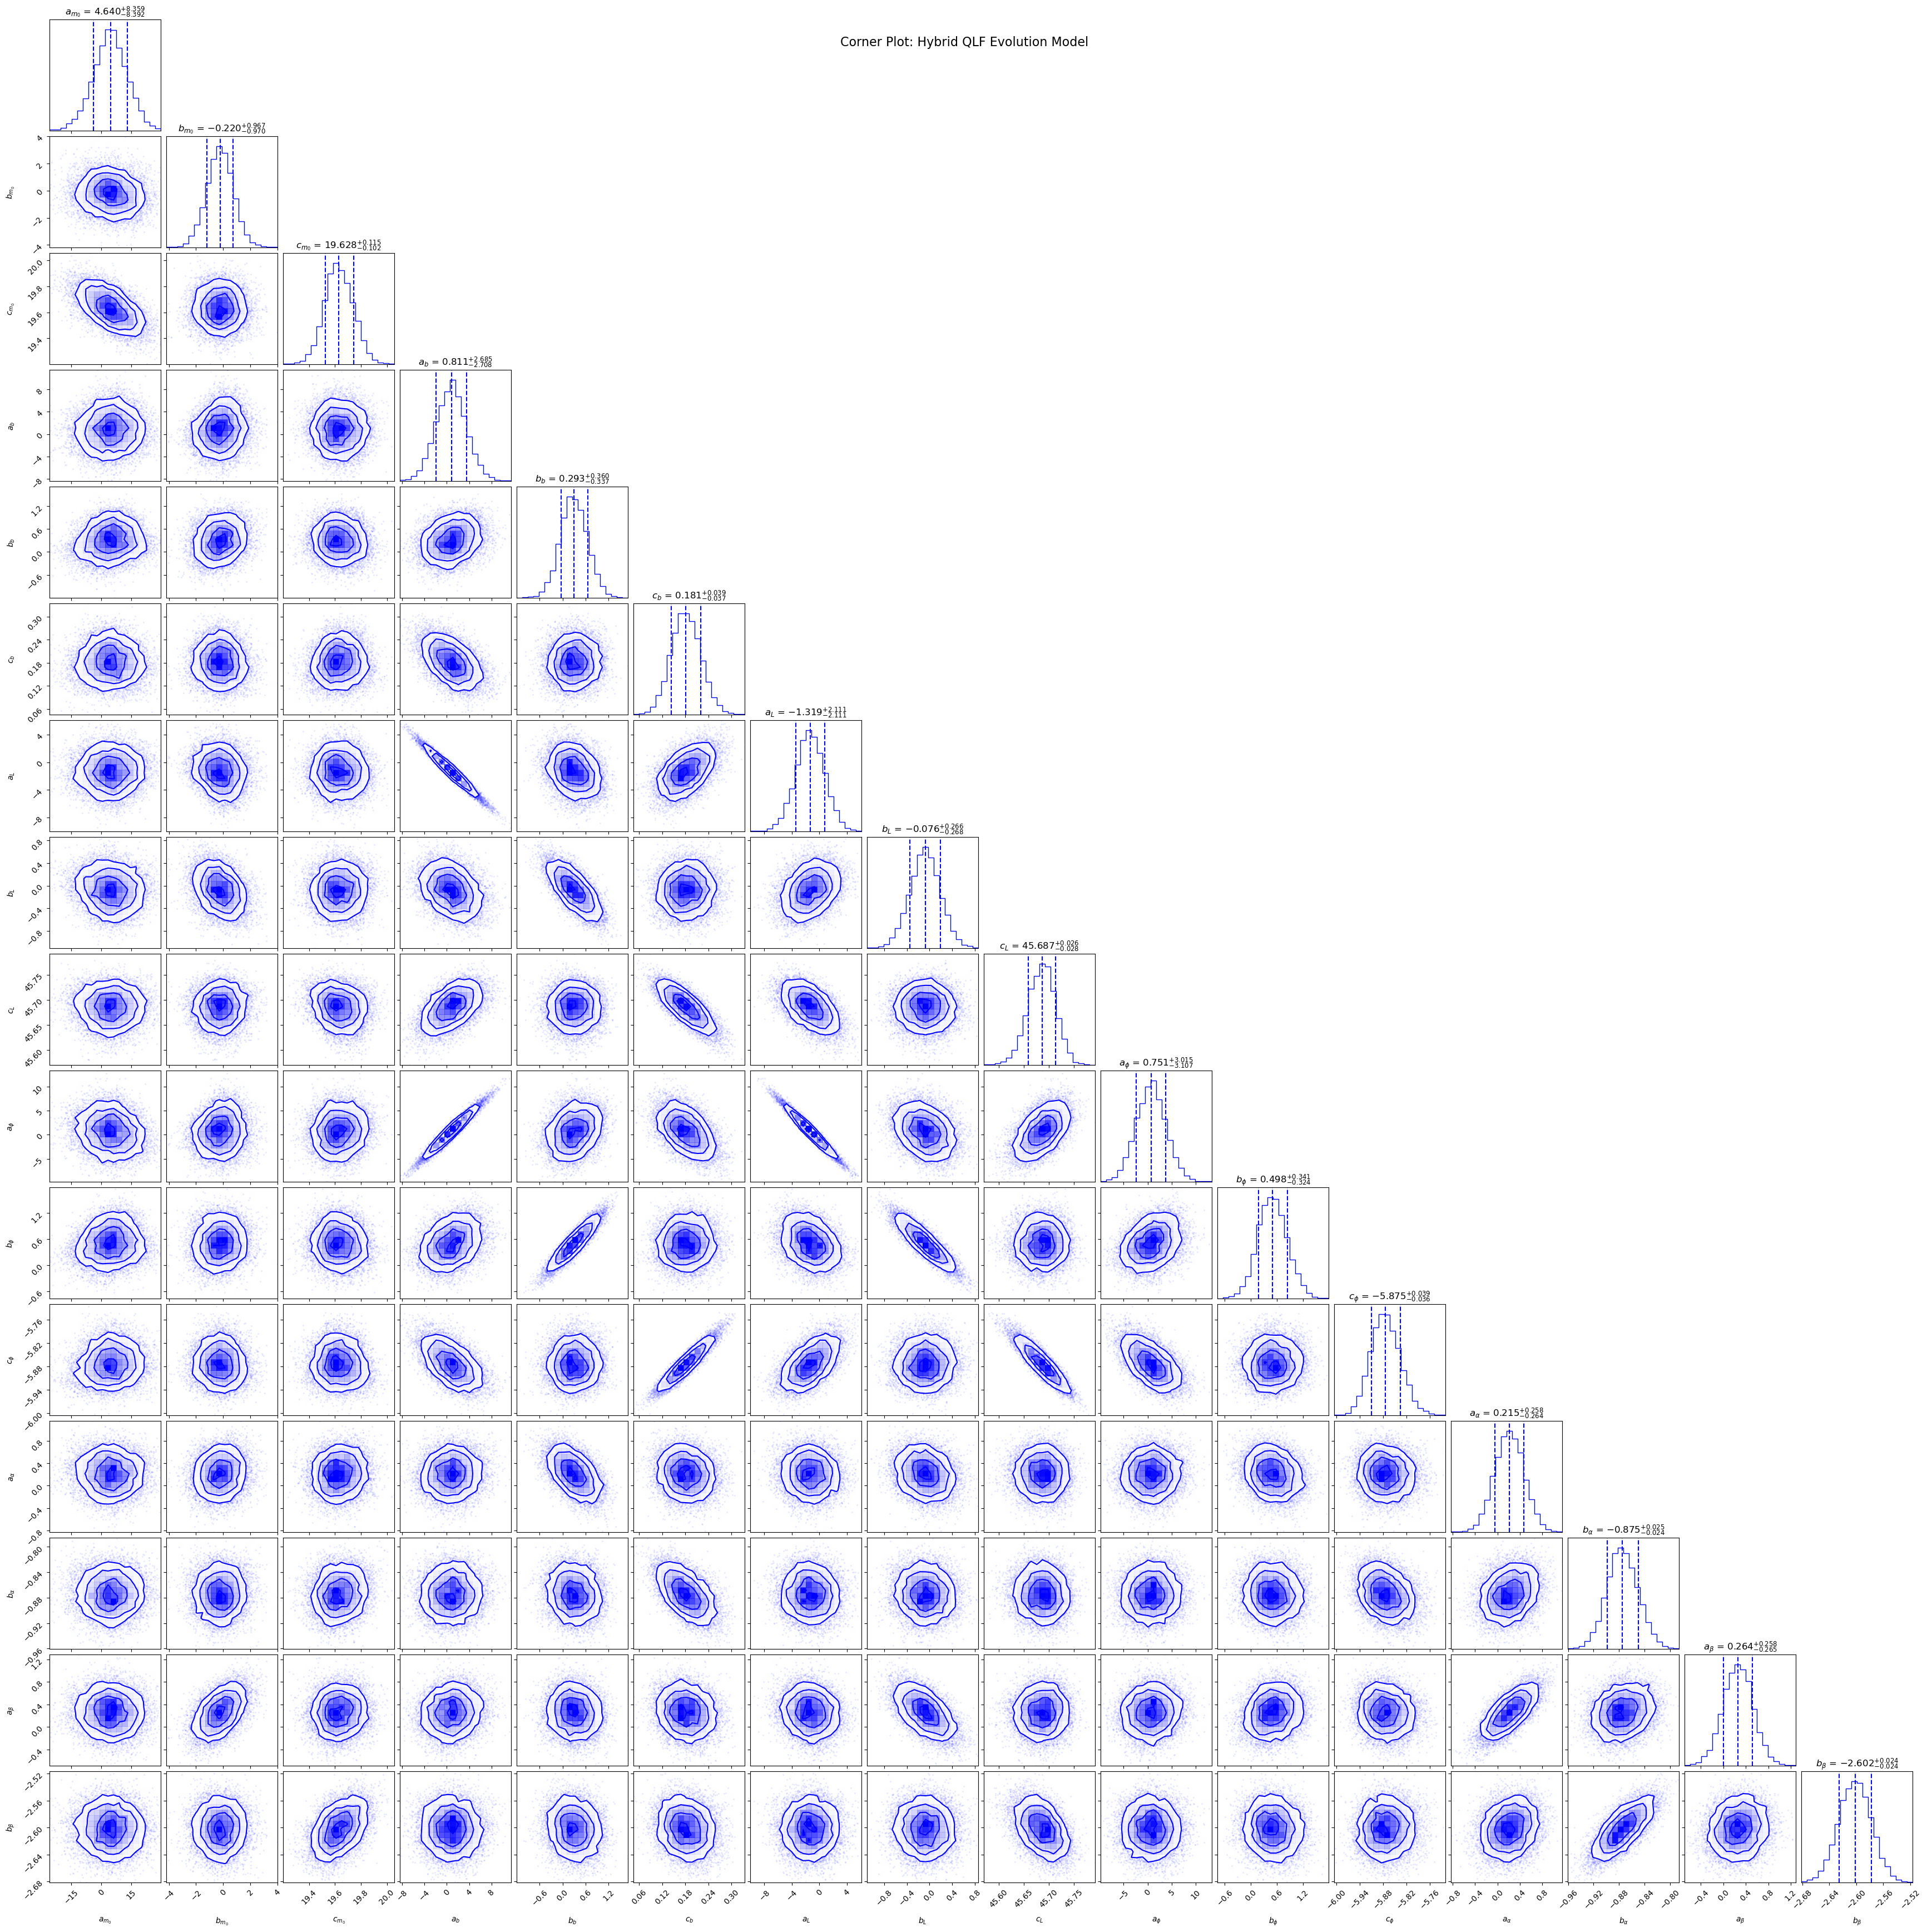

In [19]:
import corner
import matplotlib.pyplot as plt
import numpy as np

samples = mcmc.get_samples()

# Stack 15 parameters
samples_array = np.vstack((
    samples['a_m0'], samples['b_m0'], samples['c_m0'],
    samples['a_b'], samples['b_b'], samples['c_b'],
    samples['aL'], samples['bL'], samples['cL'],
    samples['aP'], samples['bP'], samples['cP'],
    samples['a_alpha'], samples['b_alpha'],
    samples['a_beta'], samples['b_beta']
)).T

# Labels for 15 parameters
labels = [
    r"$a_{m_0}$", r"$b_{m_0}$", r"$c_{m_0}$",
    r"$a_{b}$", r"$b_{b}$", r"$c_{b}$",
    r"$a_{L}$", r"$b_{L}$", r"$c_{L}$",
    r"$a_{\phi}$", r"$b_{\phi}$", r"$c_{\phi}$",
    r"$a_{\alpha}$", r"$b_{\alpha}$",
    r"$a_{\beta}$", r"$b_{\beta}$"
]

fig = corner.corner(
    samples_array, labels=labels,
    show_titles=True, quantiles=[0.16, 0.5, 0.84],
    plot_contours=True, color='blue',
    title_kwargs={"fontsize": 12}, title_fmt=".3f"
)

fig.suptitle('Corner Plot: Hybrid QLF Evolution Model', fontsize=16)
plt.show()

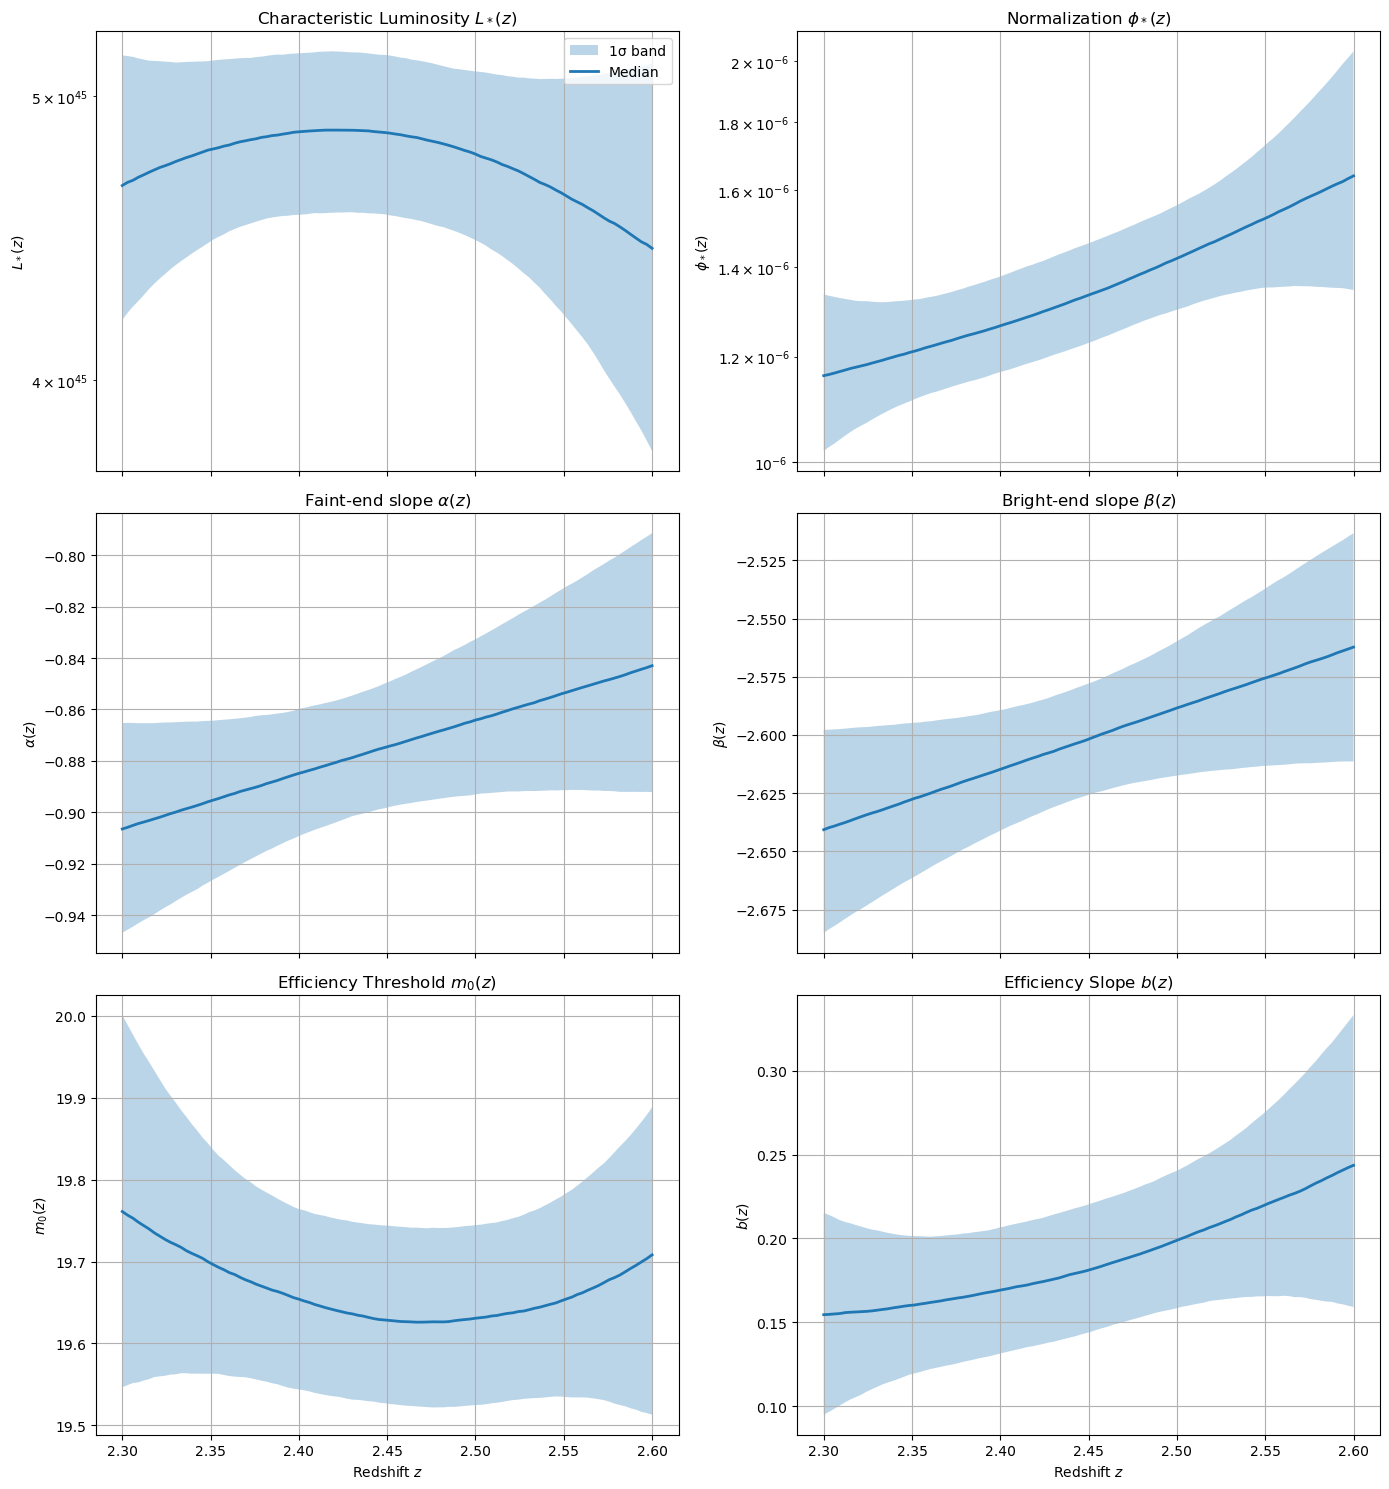

In [20]:
z_grid = np.linspace(2.3, 2.6, 100)
delta_z = z_grid - 2.45  # consistent with z_ref in ln_posterior3

# Quadratic evolution
L_star_z = 10 ** (
    samples['aL'][:, None] * delta_z**2 +
    samples['bL'][:, None] * delta_z +
    samples['cL'][:, None]
)

phi_star_z = 10 ** (
    samples['aP'][:, None] * delta_z**2 +
    samples['bP'][:, None] * delta_z +
    samples['cP'][:, None]
)

m0_z = (
    samples['a_m0'][:, None] * delta_z**2 +
    samples['b_m0'][:, None] * delta_z +
    samples['c_m0'][:, None]
)

b_z = (
    samples['a_b'][:, None] * delta_z**2 +
    samples['b_b'][:, None] * delta_z +
    samples['c_b'][:, None]
)

# Linear evolution
alpha_z = (
    samples['a_alpha'][:, None] * delta_z +
    samples['b_alpha'][:, None]
)

beta_z = (
    samples['a_beta'][:, None] * delta_z +
    samples['b_beta'][:, None]
)

# Compute percentiles
def get_percentiles(samples_z):
    median = np.median(samples_z, axis=0)
    p16 = np.percentile(samples_z, 16, axis=0)
    p84 = np.percentile(samples_z, 84, axis=0)
    return median, p16, p84

L_median, L_p16, L_p84 = get_percentiles(L_star_z)
phi_median, phi_p16, phi_p84 = get_percentiles(phi_star_z)
alpha_median, alpha_p16, alpha_p84 = get_percentiles(alpha_z)
beta_median, beta_p16, beta_p84 = get_percentiles(beta_z)
m0_median, m0_p16, m0_p84 = get_percentiles(m0_z)
b_median, b_p16, b_p84 = get_percentiles(b_z)

# Plot 3x2 layout
fig, axs = plt.subplots(3, 2, figsize=(14, 15), sharex=True)

axs[0, 0].fill_between(z_grid, L_p16, L_p84, alpha=0.3, label='1σ band')
axs[0, 0].plot(z_grid, L_median, lw=2, label='Median')
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylabel(r"$L_*(z)$")
axs[0, 0].set_title(r"Characteristic Luminosity $L_*(z)$")
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].fill_between(z_grid, phi_p16, phi_p84, alpha=0.3)
axs[0, 1].plot(z_grid, phi_median, lw=2)
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylabel(r"$\phi_*(z)$")
axs[0, 1].set_title(r"Normalization $\phi_*(z)$")
axs[0, 1].grid(True)

axs[1, 0].fill_between(z_grid, alpha_p16, alpha_p84, alpha=0.3)
axs[1, 0].plot(z_grid, alpha_median, lw=2)
axs[1, 0].set_ylabel(r"$\alpha(z)$")
axs[1, 0].set_title(r"Faint-end slope $\alpha(z)$")
axs[1, 0].grid(True)

axs[1, 1].fill_between(z_grid, beta_p16, beta_p84, alpha=0.3)
axs[1, 1].plot(z_grid, beta_median, lw=2)
axs[1, 1].set_ylabel(r"$\beta(z)$")
axs[1, 1].set_title(r"Bright-end slope $\beta(z)$")
axs[1, 1].grid(True)

axs[2, 0].fill_between(z_grid, m0_p16, m0_p84, alpha=0.3)
axs[2, 0].plot(z_grid, m0_median, lw=2)
axs[2, 0].set_ylabel(r"$m_0(z)$")
axs[2, 0].set_title(r"Efficiency Threshold $m_0(z)$")
axs[2, 0].set_xlabel("Redshift $z$")
axs[2, 0].grid(True)

axs[2, 1].fill_between(z_grid, b_p16, b_p84, alpha=0.3)
axs[2, 1].plot(z_grid, b_median, lw=2)
axs[2, 1].set_ylabel(r"$b(z)$")
axs[2, 1].set_title(r"Efficiency Slope $b(z)$")
axs[2, 1].set_xlabel("Redshift $z$")
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()